In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

import impyute as impy

from functools import reduce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.metrics import mean_squared_error

# Setting the stage

Suppose we run admissions for a college. 

We are given a population of applicants with certain HS GPAs and standardized test scores, like the ACT (our selection variables). We are interested in picking the students mostly likely to excel at our college from this population, measured by college GPA (our outcome variable).

To understand how much weight we should apply to HS GPA and test scores when making decisions, we hope to study the correlation between these variables and our outcome variable, college GPA. We will use the students we historically admitted to try to understand these relationships.

Since we only admitted students with top HS GPAs and/or test scores in the past, we are likely to observe a weaker relationship between these variables and college GPA than the relationships that actually exist. Among top students with top HS GPA and/or standardized test scores there will be some relationship betweent these variables. However, we did not admit students with low GPAs and low test scores, who would've likely have done poorly at our college. The omission of these students obfuscates the relationship between HS GPA / test scores and college GPA.

This problem is called range restriction. Let's explore if we can mitigate the issues of rejecting students with low GPAs and low test scores to uncover the true relationship these variables have with college GPA.

# Making some data

To start, we can generate some data in which HS GPA and ACT are weakly correlated and both of these variables are moderately correlated with college GPA.

We'll make a few columns to determine the population for whom we can observe outcomes. These restrictions (e.g. 25, 50, 75, 90) would be analagous to percentage of candidates we reject. The selection is indirect since we don't make admissions decisions on any individual variable, but on a combination of them.

We'll scale the variables for interpetability and use the columns we built previously to get college GPA for the filtered populations.

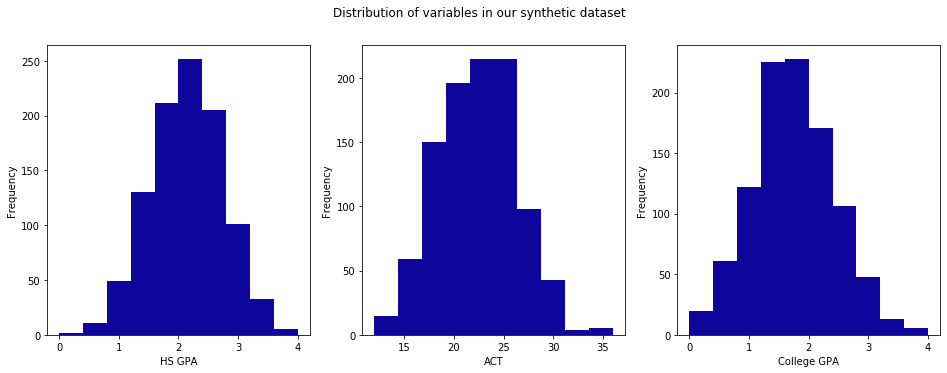

In [2]:
# Data generation
np.random.seed(123)

mean_1 = 0
mean_2 = 0
mean_3 = 0

sd_1 = 1
sd_2 = 1
sd_3 = 1

cov_0 = .2
cov_1 = .6
cov_2 = .5

df = pd.DataFrame(
    np.random.multivariate_normal(\
        [mean_1, mean_2, mean_3],
        [[sd_1, cov_0, cov_1], 
         [cov_0, sd_2, cov_2], 
         [cov_1, cov_2, sd_3]],
        1000),
        columns = ['hs_gpa', 'act', 'college_gpa']
    )


# Scale and transform to get to more familiar distirbutions
df.hs_gpa = np.round(4 * (df.hs_gpa - df.hs_gpa.min()) / (df.hs_gpa - df.hs_gpa.min()).max(), 3)

df.act = 12 + np.round(24 * (df.act - df.act.min()) / (df.act - df.act.min()).max())

df.college_gpa = np.round(4 * (df.college_gpa - df.college_gpa.min()) / (df.college_gpa - df.college_gpa.min()).max(), 3)

# (Indirect) selection
df['admitted_25'] = (9*df.hs_gpa + df.act) > (9*df.hs_gpa + df.act).quantile(.25)
df['admitted_50'] = (9*df.hs_gpa + df.act) > (9*df.hs_gpa + df.act).quantile(.50)
df['admitted_75'] = (9*df.hs_gpa + df.act) > (9*df.hs_gpa + df.act).quantile(.75)
df['admitted_90'] = (9*df.hs_gpa + df.act) > (9*df.hs_gpa + df.act).quantile(.90)


df['college_gpa_25'] = np.nan
df.loc[df.admitted_25, 'college_gpa_25'] =  df.college_gpa

df['college_gpa_50'] = np.nan
df.loc[df.admitted_50, 'college_gpa_50'] =  df.college_gpa

df['college_gpa_75'] = np.nan
df.loc[df.admitted_75, 'college_gpa_75'] =  df.college_gpa

df['college_gpa_90'] = np.nan
df.loc[df.admitted_90, 'college_gpa_90'] =  df.college_gpa

fig, axs = plt.subplots(1,3)
fig.set_size_inches(16, 16/3)

df.hs_gpa.plot(kind = 'hist',  color = '#0e069b', ax = axs[0])
df.act.plot(kind = 'hist',  color = '#0e069b', ax = axs[1])
df.college_gpa.plot(kind = 'hist',  color = '#0e069b', ax = axs[2])

axs[0].set_xlabel('HS GPA')
axs[1].set_xlabel('ACT')
axs[2].set_xlabel('College GPA')

fig.suptitle('Distribution of variables in our synthetic dataset');

In [3]:
df.corr().loc[['hs_gpa', 'act', 'college_gpa'], ['hs_gpa', 'act', 'college_gpa']]

,hs_gpa,act,college_gpa
hs_gpa,1.000000,0.155183,0.583948
act,0.155183,1.000000,0.469940
college_gpa,0.583948,0.469940,1.000000


We've now got some data in which high school GPA and standardized test score are weakly correlated, and in which they are moderately correlated with college GPA. That is to say, high school GPA and ACT score are orthogonal reads (in our dataset), each offering predictive value in estimating an applicants college GPA (in our dataset).

# The impact of selection

Under each of the admissions schemas, we end up damaging our understanding of the correlation between selection and outcome variables. Let's look at the case with 90% restriction in our available sample.

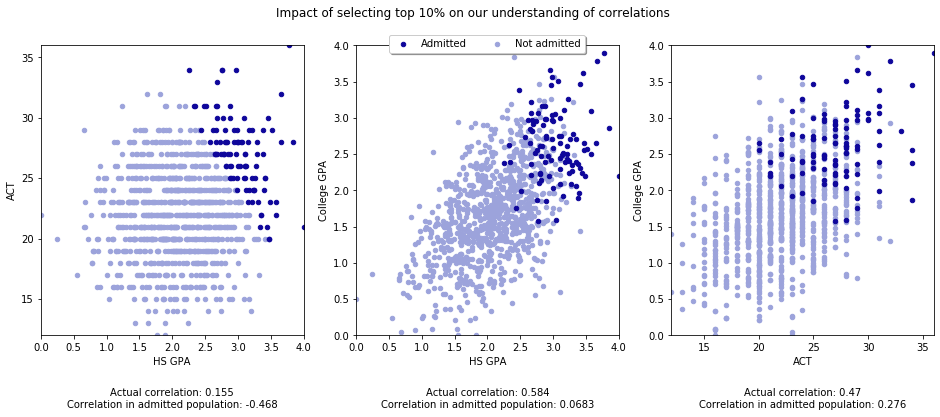

In [4]:
# Visualization

fig, axs = plt.subplots(1,3)
fig.set_size_inches(16, 16/3)

df[df.admitted_90==False]\
    .plot('hs_gpa', 'act', kind = 'scatter', color = '#9ca3db', ax = axs[0])

df[df.admitted_90==True]\
    .plot('hs_gpa', 'act', kind = 'scatter', color = '#0e069b', ax = axs[0])

df[df.admitted_90==False]\
    .plot('hs_gpa', 'college_gpa', kind = 'scatter', 
          color = '#9ca3db', label = 'Not admitted', ax = axs[1])

df[df.admitted_90==True]\
    .plot('hs_gpa', 'college_gpa', kind = 'scatter', color = '#0e069b', label = 'Admitted', ax = axs[1])


df[df.admitted_90==False]\
    .plot('act', 'college_gpa', kind = 'scatter', 
          color = '#9ca3db', ax = axs[2])

df[df.admitted_90==True]\
    .plot('act', 'college_gpa', kind = 'scatter', color = '#0e069b', ax = axs[2])

axs[0].set_xlim([0, 4])
axs[0].set_ylim([12, 36])

axs[1].set_xlim([0, 4])
axs[1].set_ylim([0, 4])

axs[2].set_xlim([12, 36])
axs[2].set_ylim([0, 4])

# Correlations
obs_corr = df[df.admitted_90].corr().loc['hs_gpa', 'act']
act_corr = df.corr().loc['hs_gpa', 'act']
corr_text = 'Actual correlation: {:.3}\nCorrelation in admitted population: {:.3}'.format(act_corr, obs_corr)
axs[0].text(2, 6, corr_text, ha='center')

obs_corr = df[df.admitted_90].corr().loc['hs_gpa', 'college_gpa']
act_corr = df.corr().loc['hs_gpa', 'college_gpa']
corr_text = 'Actual correlation: {:.3}\nCorrelation in admitted population: {:.3}'.format(act_corr, obs_corr)
axs[1].text(2, -1, corr_text, ha='center')

obs_corr = df[df.admitted_90].corr().loc['act', 'college_gpa']
act_corr = df.corr().loc['act', 'college_gpa']
corr_text = 'Actual correlation: {:.3}\nCorrelation in admitted population: {:.3}'.format(act_corr, obs_corr)
axs[2].text(24, -1, corr_text, ha='center')

handles, labels = axs[1].get_legend_handles_labels()
order = [1,0]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc = (.125, .975), fancybox=True, shadow=True, ncol=2)

axs[0].set_xlabel('HS GPA')
axs[0].set_ylabel('ACT')
axs[1].set_xlabel('HS GPA')
axs[1].set_ylabel('College GPA')
axs[2].set_xlabel('ACT')
axs[2].set_ylabel('College GPA')

fig.suptitle('Impact of selecting top 10% on our understanding of correlations');

Selection will not impact our understanding of the relationship between HS GPA and ACT, since we observe this for applicants, regardless of our admission decision. However, it is helpful to see that, for admitted students, there is a negative correlation between these variables since, at a mimumum, applicants must spike on one variable or do relatively well on both to get admitted.

Looking to the left two plots, we see that by limiting who we admit, the correlations between the selection variables, HS GPA and ACT, and the outcome variable, college GPA, are muted.  Since we did not admit students with worse chances of sucesss, we see less variation in selection variables than we would if we admitted all students. Our outcome variables have some variation due to the non-perfect correlation that exists between our selection and outcome variables, but less than we would observe if admitted all applicants.

In [5]:
printmd("**Correlation between HS and college GPA**")
print('Unrestricted: {:.3}'.format(df.corr().loc['hs_gpa', 'college_gpa']))

print('25% restricted: {:.3}'.format(df.corr()\
                                     .loc['hs_gpa', 'college_gpa_25']))

print('50% restricted: {:.3}'.format(df.corr()\
                                     .loc['hs_gpa', 'college_gpa_50']))

print('75% restricted: {:.3}'.format(df.corr()\
                                     .loc['hs_gpa', 'college_gpa_75']))

print('90% restricted: {:.3}'.format(df.corr()\
                                     .loc['hs_gpa', 'college_gpa_90']))

printmd("**Correlation between ACT and college GPA**")
print('Unrestricted: {:.3}'.format(df.corr().loc['act', 'college_gpa']))

print('25% restricted: {:.3}'.format(df.corr()\
                                     .loc['act', 'college_gpa_25']))

print('50% restricted: {:.3}'.format(df.corr()\
                                     .loc['act', 'college_gpa_50']))

print('75% restricted: {:.3}'.format(df.corr()\
                                     .loc['act', 'college_gpa_75']))

print('90% restricted: {:.3}'.format(df.corr()\
                                     .loc['act', 'college_gpa_90']))

**Correlation between HS and college GPA**

Unrestricted: 0.584
25% restricted: 0.427
50% restricted: 0.355
75% restricted: 0.221
90% restricted: 0.0683


**Correlation between ACT and college GPA**

Unrestricted: 0.47
25% restricted: 0.347
50% restricted: 0.282
75% restricted: 0.238
90% restricted: 0.276


In the most extreme case, we only observe outcomes for 10% of the population and the observed correlations are most different from the actual correlations. Still, underreporting is a risk undera all schemas.

If administration only saw the points for admitted students, they may question our decision to make admissions decisions using either GPA or ACT. We ought to use statistics to create a defense for this action, as it really is reasonable based on the data we have available. 

# EM Algorithm to impute

The Expectation-maximization (EM) algorithm is a common technique for imputing censored data. It attempts to recover missing data drawn from some distribution by using observed data to estimate mean, variance, and correlation parameters that define the distribution. The EM Algorithm is an iterative technique that alternates between two steps to estimate the parameters, after setting some initial estimate:
<ul>
  <li>Maximization (M) step that generates parameters maximizing the expected log-likelihood</li>
  <li>Expectation (E) step that generates estimates for missing data given the observed data related to it</li>
</ul>
This process continues until the difference between parameter estimates becomes arbitrarily small.

### Junkyu Parks's EM algorithm

Junkyu Park has an implementation available [HERE](https://joon3216.github.io/research_materials/2019/em_imputation_python.html) that we can test with.

In [6]:
def impute_em(X, max_iter = 3000, eps = 1e-08):
    '''(np.array, int, number) -> {str: np.array or int}
    
    Precondition: max_iter >= 1 and eps > 0
    
    Return the dictionary with five keys where:
    - Key 'mu' stores the mean estimate of the imputed data.
    - Key 'Sigma' stores the variance estimate of the imputed data.
    - Key 'X_imputed' stores the imputed data that is mutated from X using 
      the EM algorithm.
    - Key 'C' stores the np.array that specifies the original missing entries
      of X.
    - Key 'iteration' stores the number of iteration used to compute
      'X_imputed' based on max_iter and eps specified.
    '''
    
    nr, nc = X.shape
    C = np.isnan(X) == False
    
    # Collect M_i and O_i's
    one_to_nc = np.arange(1, nc + 1, step = 1)
    M = one_to_nc * (C == False) - 1
    O = one_to_nc * C - 1
    
    # Generate Mu_0 and Sigma_0
    Mu = np.nanmean(X, axis = 0)
    observed_rows = np.where(np.isnan(sum(X.T)) == False)[0]
    S = np.cov(X[observed_rows, ].T)
    if np.isnan(S).any():
        S = np.diag(np.nanvar(X, axis = 0))
    
    # Start updating
    Mu_tilde, S_tilde = {}, {}
    X_tilde = X.copy()
    no_conv = True
    iteration = 0
    while no_conv and iteration < max_iter:
        for i in range(nr):
            S_tilde[i] = np.zeros(nc ** 2).reshape(nc, nc)
            if set(O[i, ]) != set(one_to_nc - 1): # missing component exists
                M_i, O_i = M[i, ][M[i, ] != -1], O[i, ][O[i, ] != -1]
                S_MM = S[np.ix_(M_i, M_i)]
                S_MO = S[np.ix_(M_i, O_i)]
                S_OM = S_MO.T
                S_OO = S[np.ix_(O_i, O_i)]
                Mu_tilde[i] = Mu[np.ix_(M_i)] +\
                    S_MO @ np.linalg.inv(S_OO) @\
                    (X_tilde[i, O_i] - Mu[np.ix_(O_i)])
                X_tilde[i, M_i] = Mu_tilde[i]
                S_MM_O = S_MM - S_MO @ np.linalg.inv(S_OO) @ S_OM
                S_tilde[i][np.ix_(M_i, M_i)] = S_MM_O
        Mu_new = np.mean(X_tilde, axis = 0)
        S_new = np.cov(X_tilde.T, bias = 1) +\
            reduce(np.add, S_tilde.values()) / nr
        no_conv =\
            np.linalg.norm(Mu - Mu_new) >= eps or\
            np.linalg.norm(S - S_new, ord = 2) >= eps
        Mu = Mu_new
        S = S_new
        iteration += 1
    
    result = {
        'mu': Mu,
        'Sigma': S,
        'X_imputed': X_tilde,
        'C': C,
        'iteration': iteration
    }
    
    return result

In [7]:
# Imputation
max_iter = 1000
eps = .001

df['college_gpa_em_25'] = pd.DataFrame(impute_em(df[['hs_gpa', 'act', 'college_gpa_25']].values.astype(float),
    max_iter = max_iter, eps = eps)['X_imputed'],
    columns = ['hs_gpa', 'act', 'college_gpa'])['college_gpa']

df['college_gpa_em_50'] = pd.DataFrame(impute_em(df[['hs_gpa', 'act', 'college_gpa_50']].values.astype(float),
   max_iter = max_iter, eps = eps)['X_imputed'],
    columns = ['hs_gpa', 'act', 'college_gpa'])['college_gpa']

df['college_gpa_em_75'] = pd.DataFrame(impute_em(df[['hs_gpa', 'act', 'college_gpa_75']].values.astype(float),
   max_iter = max_iter, eps = eps)['X_imputed'],
    columns = ['hs_gpa', 'act', 'college_gpa'])['college_gpa']

df['college_gpa_em_90'] = pd.DataFrame(impute_em(df[['hs_gpa', 'act', 'college_gpa_90']].values.astype(float),
    max_iter = max_iter, eps = eps)['X_imputed'],
    columns = ['hs_gpa', 'act', 'college_gpa'])['college_gpa']

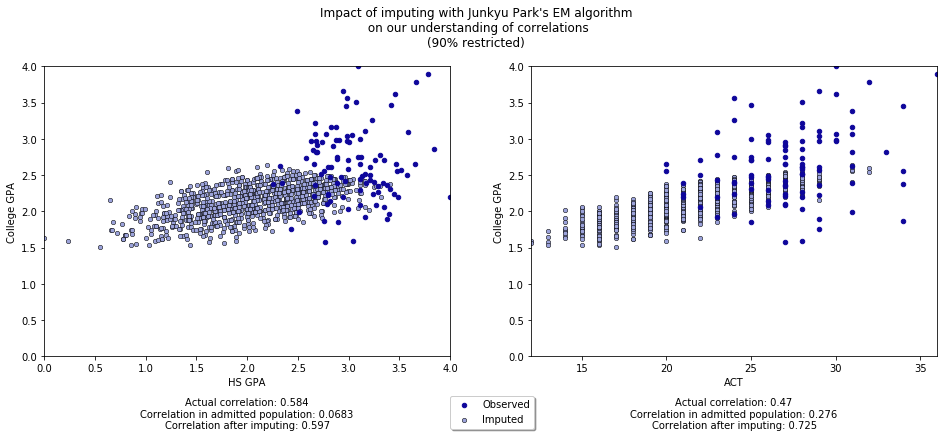

In [8]:
# Visualization
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 16/3)

df[~df.admitted_90]\
    .plot('hs_gpa', 'college_gpa_em_90', kind = 'scatter',  color = '#9ca3db', edgecolor='k', linewidth=.5, ax = axs[0])
df\
    .plot('hs_gpa', 'college_gpa_90', kind = 'scatter', color = '#0e069b', ax = axs[0])

df[~df.admitted_90]\
    .plot('act', 'college_gpa_em_90', kind = 'scatter',  color = '#9ca3db', edgecolor='k', linewidth=.5,
          label = 'Imputed', ax = axs[1])
df\
    .plot('act', 'college_gpa_90', kind = 'scatter', color = '#0e069b', label = 'Observed', ax = axs[1])

axs[0].set_xlim([0, 4])
axs[0].set_ylim([0, 4])

axs[1].set_xlim([12, 36])
axs[1].set_ylim([0, 4])

act_corr = df.corr().loc['hs_gpa', 'college_gpa']
obs_corr = df.corr().loc['hs_gpa', 'college_gpa_90']
imp_corr = df.corr().loc['hs_gpa', 'college_gpa_em_90']

corr_text = 'Actual correlation: {:.3}\nCorrelation in admitted population: {:.3}\n'.format(act_corr, obs_corr) +\
     'Correlation after imputing: {:.3}'.format(imp_corr)

axs[0].text(2, -1, 
           corr_text,
            size=10,
            horizontalalignment='center')

act_corr = df.corr().loc['act', 'college_gpa']
obs_corr = df.corr().loc['act', 'college_gpa_90']
imp_corr = df.corr().loc['act', 'college_gpa_em_90']

corr_text = 'Actual correlation: {:.3}\nCorrelation in admitted population: {:.3}\n'.format(act_corr, obs_corr) +\
     'Correlation after imputing: {:.3}'.format(imp_corr)

axs[1].text(24, -1, 
           corr_text,
            size=10,
            horizontalalignment='center')

handles, labels = axs[1].get_legend_handles_labels()
order = [1,0]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc = (-.2, -.25), fancybox=True, shadow=True, ncol=1)

axs[0].set_xlabel('HS GPA')
axs[0].set_ylabel('College GPA')
axs[1].set_xlabel('ACT')
axs[1].set_ylabel('College GPA')

fig.suptitle('Impact of imputing with Junkyu Park\'s EM algorithm\n on our understanding of correlations\n(90% restricted)',
             va = 'center');

While the imputated values may look strange due to how densely they are distributed, the correlations after imputing are closer, as a pair, to the actual values than simply correlating observed outcomes. We can also look at the impact for other admissions schemas.

In [9]:
printmd("**Correlation between HS and college GPA**")
print('Actual: {:.3}'.format( df.corr().loc['hs_gpa', 'college_gpa']))
print('25% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_25'],
        df.corr()\
            .loc['hs_gpa', 'college_gpa_em_25']
    )
)

print('50% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_50'],
        df.corr()\
            .loc['hs_gpa', 'college_gpa_em_50']
    )
)

print('75% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_75'],
        df.corr()\
            .loc['hs_gpa', 'college_gpa_em_75']
    )
)

print('90% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_90'],
        df.corr()\
            .loc['hs_gpa', 'college_gpa_em_90']
    )
)

printmd("**Correlation between ACT and college GPA**")
print('Actual: {:.3}'.format( df.corr().loc['act', 'college_gpa']))
print('25% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_25'],
        df.corr()\
            .loc['act', 'college_gpa_em_25']
    )
)

print('50% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_50'],
        df.corr()\
            .loc['act', 'college_gpa_em_50']
    )
)

print('75% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_75'],
        df.corr()\
            .loc['act', 'college_gpa_em_75']
    )
)

print('90% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_90'],
        df.corr()\
            .loc['act', 'college_gpa_em_90']
    )
)

**Correlation between HS and college GPA**

Actual: 0.584
25% restricted: 
	Before imputing: 0.427
	After imputing: 0.623
50% restricted: 
	Before imputing: 0.355
	After imputing: 0.682
75% restricted: 
	Before imputing: 0.221
	After imputing: 0.699
90% restricted: 
	Before imputing: 0.0683
	After imputing: 0.597


**Correlation between ACT and college GPA**

Actual: 0.47
25% restricted: 
	Before imputing: 0.347
	After imputing: 0.504
50% restricted: 
	Before imputing: 0.282
	After imputing: 0.549
75% restricted: 
	Before imputing: 0.238
	After imputing: 0.597
90% restricted: 
	Before imputing: 0.276
	After imputing: 0.725


The results are generally better, but there may be a tendency to overcorrect. There are other technqiues to correct for range restriction that we might want to explore.

# MICE to impute

Multivariate imputation by chained equations (MICE) is a relatively new technique that uses, you guessed it, multiple imputations to get to the final imputation. Copies of the dataset are made, and the following procedure is applied to each dataset:
<ul>
  <li>The nonmissing data is used to generate a model to predict missing data, one variable at at a time</li>
  <li>After filling in the missing data, the process of trying to model the missing variables is repeated using the newly imputed data</li>
</ul>
Results obtained for each copy of the dataset are then pooled together to get to a final imputation for each missing data.

### scikit-learn's MICE implementation

In [10]:
imputer = IterativeImputer()

df['college_gpa_mice_25'] = pd.DataFrame(imputer.fit_transform(df[['hs_gpa', 'act', 'college_gpa_25']]), 
                                      columns = ['hs_gpa', 'act', 'college_gpa'])['college_gpa']

df['college_gpa_mice_50'] = pd.DataFrame(imputer.fit_transform(df[['hs_gpa', 'act', 'college_gpa_50']]), 
                                      columns = ['hs_gpa', 'act', 'college_gpa'])['college_gpa']

df['college_gpa_mice_75'] = pd.DataFrame(imputer.fit_transform(df[['hs_gpa', 'act', 'college_gpa_75']]), 
                                      columns = ['hs_gpa', 'act', 'college_gpa'])['college_gpa']

df['college_gpa_mice_90'] = pd.DataFrame(imputer.fit_transform(df[['hs_gpa', 'act', 'college_gpa_90']]), 
                                      columns = ['hs_gpa', 'act', 'college_gpa'])['college_gpa']

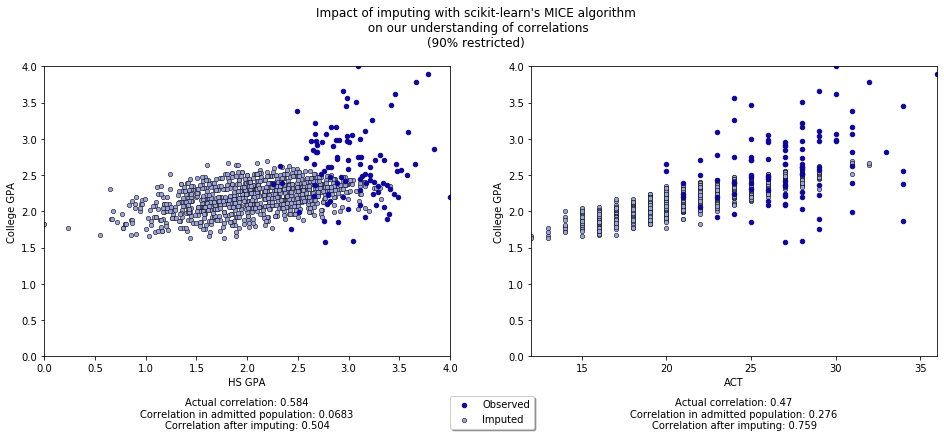

In [11]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 16/3)

df[~df.admitted_90]\
    .plot('hs_gpa', 'college_gpa_mice_90', kind = 'scatter',  color = '#9ca3db', edgecolor='k', linewidth=.5, ax = axs[0])
df\
    .plot('hs_gpa', 'college_gpa_90', kind = 'scatter', color = '#0e069b', ax = axs[0])

df[~df.admitted_90]\
    .plot('act', 'college_gpa_mice_90', kind = 'scatter',  color = '#9ca3db', edgecolor='k', linewidth=.5,
          label = 'Imputed', ax = axs[1])
df\
    .plot('act', 'college_gpa_90', kind = 'scatter', color = '#0e069b', label = 'Observed', ax = axs[1])

axs[0].set_xlim([0, 4])
axs[0].set_ylim([0, 4])

axs[1].set_xlim([12, 36])
axs[1].set_ylim([0, 4])

act_corr = df.corr().loc['hs_gpa', 'college_gpa']
obs_corr = df.corr().loc['hs_gpa', 'college_gpa_90']
imp_corr = df.corr().loc['hs_gpa', 'college_gpa_mice_90']

corr_text = 'Actual correlation: {:.3}\nCorrelation in admitted population: {:.3}\n'.format(act_corr, obs_corr) +\
     'Correlation after imputing: {:.3}'.format(imp_corr)

axs[0].text(2, -1, 
           corr_text,
            size=10,
            horizontalalignment='center')

act_corr = df.corr().loc['act', 'college_gpa']
obs_corr = df.corr().loc['act', 'college_gpa_90']
imp_corr = df.corr().loc['act', 'college_gpa_mice_90']

corr_text = 'Actual correlation: {:.3}\nCorrelation in admitted population: {:.3}\n'.format(act_corr, obs_corr) +\
     'Correlation after imputing: {:.3}'.format(imp_corr)

axs[1].text(24, -1, 
           corr_text,
            size=10,
            horizontalalignment='center')

handles, labels = axs[1].get_legend_handles_labels()
order = [1,0]
axs[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc = (-.2, -.25), fancybox=True, shadow=True, ncol=1)

axs[0].set_xlabel('HS GPA')
axs[0].set_ylabel('College GPA')
axs[1].set_xlabel('ACT')
axs[1].set_ylabel('College GPA')

fig.suptitle('Impact of imputing with scikit-learn\'s MICE algorithm\n on our understanding of correlations\n(90% restricted)',
             va = 'center');

It appears that, in our most restricted case, MICE might get us closer to actual correlations than using observations alone, but overcorrection is a risk here as well. Let's check the other cases too.

In [12]:
printmd("**Correlation between HS and college GPA**")
print('Actual: {:.3}'.format( df.corr().loc['hs_gpa', 'college_gpa']))
print('25% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_25'],
        df.corr()\
            .loc['hs_gpa', 'college_gpa_mice_25']
    )
)

print('50% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_50'],
        df.corr()\
            .loc['hs_gpa', 'college_gpa_mice_50']
    )
)

print('75% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_75'],
        df.corr()\
            .loc['hs_gpa', 'college_gpa_mice_75']
    )
)

print('90% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_90'],
        df.corr()\
            .loc['hs_gpa', 'college_gpa_mice_90']
    )
)

printmd("**Correlation between ACT and college GPA**")
print('Actual: {:.3}'.format( df.corr().loc['act', 'college_gpa']))
print('25% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_25'],
        df.corr()\
            .loc['act', 'college_gpa_mice_25']
    )
)

print('50% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_50'],
        df.corr()\
            .loc['act', 'college_gpa_mice_50']
    )
)

print('75% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_75'],
        df.corr()\
            .loc['act', 'college_gpa_mice_75']
    )
)

print('90% restricted: \n\tBefore imputing: {:.3}\n\tAfter imputing: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_90'],
        df.corr()\
            .loc['act', 'college_gpa_mice_90']
    )
)

**Correlation between HS and college GPA**

Actual: 0.584
25% restricted: 
	Before imputing: 0.427
	After imputing: 0.622
50% restricted: 
	Before imputing: 0.355
	After imputing: 0.68
75% restricted: 
	Before imputing: 0.221
	After imputing: 0.692
90% restricted: 
	Before imputing: 0.0683
	After imputing: 0.504


**Correlation between ACT and college GPA**

Actual: 0.47
25% restricted: 
	Before imputing: 0.347
	After imputing: 0.504
50% restricted: 
	Before imputing: 0.282
	After imputing: 0.55
75% restricted: 
	Before imputing: 0.238
	After imputing: 0.601
90% restricted: 
	Before imputing: 0.276
	After imputing: 0.759


Overcorrection is an issue with MICE too, but still allows us to get closer to the actual correlation than simply using observed outcomes.

What other tools are out there?

# Thorndike’s case C formula for indirect selection
Social scientists have a toolkit for addressing range restriction as well. [HERE](https://www.jstor.org/stable/1434977) is some discussion of the technique that has been used by psychologists for decades when trying to correct for indirect selection, as well as a comparison against the EM algorithm and MICE.

We can implement Thorndike’s case C formula below.

In [13]:
def thorndike_case_c(df, col_X, col_Z, col_Y):
    r_x_y_obs = df.loc[df[col_Y].notnull(), [col_X, col_Y]].corr().iloc[0, 1]
    r_z_x_obs = df.loc[df[col_Y].notnull(), [col_Z, col_X]].corr().iloc[0, 1]
    r_z_y_obs = df.loc[df[col_Y].notnull(), [col_Z, col_Y]].corr().iloc[0, 1]
    
    sd_z_obs = df.loc[df[col_Y].notnull(), col_Z].std()
    sd_z = df.loc[:, col_Z].std()
    
    r_y_x_all = (r_x_y_obs - (r_z_x_obs * r_z_y_obs) + (r_z_x_obs * r_z_y_obs * ((sd_z / sd_z_obs)**2))) /\
        np.sqrt((1 - (r_z_x_obs**2) + ((r_z_x_obs**2) * ((sd_z / sd_z_obs)**2))) *\
               (1 - (r_z_y_obs**2) + ((r_z_y_obs**2) * ((sd_z / sd_z_obs)**2)))
               )
    return r_y_x_all

Unfortunately, there will be no pretty pictures to pair with updated correlation estimates as we are not imputing any values.

In [14]:
df['selection_var'] = (9 * df.hs_gpa) + df.act

printmd("**Correlation between HS and college GPA**")
print('Actual: {:.3}'.format( df.corr().loc['hs_gpa', 'college_gpa']))
print('25% restricted: \n\tBefore correcting: {:.3}\n\tAfter correcting: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_25'],
        thorndike_case_c(df, 'hs_gpa', 'selection_var', 'college_gpa_25')
    )
)

print('50% restricted: \n\tBefore correcting: {:.3}\n\tAfter correcting: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_50'],
        thorndike_case_c(df, 'hs_gpa', 'selection_var', 'college_gpa_50')
    )
)

print('75% restricted: \n\tBefore correcting: {:.3}\n\tAfter correcting: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_75'],
        thorndike_case_c(df, 'hs_gpa', 'selection_var', 'college_gpa_75')
    )
)

print('90% restricted: \n\tBefore correcting: {:.3}\n\tAfter correcting: {:.3}'\
    .format(
        df.corr()\
            .loc['hs_gpa', 'college_gpa_90'],
        thorndike_case_c(df, 'hs_gpa', 'selection_var', 'college_gpa_90')
    )
)

printmd("**Correlation between ACT and college GPA**")
print('Actual: {:.3}'.format( df.corr().loc['act', 'college_gpa']))
print('25% restricted: \n\tBefore correcting: {:.3}\n\tAfter correcting: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_25'],
        thorndike_case_c(df, 'act', 'selection_var', 'college_gpa_25')
    )
)

print('50% restricted: \n\tBefore correcting: {:.3}\n\tAfter correcting: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_50'],
        thorndike_case_c(df, 'act', 'selection_var', 'college_gpa_50')
    )
)

print('75% restricted: \n\tBefore correcting: {:.3}\n\tAfter correcting: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_75'],
        thorndike_case_c(df, 'act', 'selection_var', 'college_gpa_75')
    )
)

print('90% restricted: \n\tBefore correcting: {:.3}\n\tAfter correcting: {:.3}'\
    .format(
        df.corr()\
            .loc['act', 'college_gpa_90'],
        thorndike_case_c(df, 'act', 'selection_var', 'college_gpa_90')
    )
)

**Correlation between HS and college GPA**

Actual: 0.584
25% restricted: 
	Before correcting: 0.427
	After correcting: 0.574
50% restricted: 
	Before correcting: 0.355
	After correcting: 0.588
75% restricted: 
	Before correcting: 0.221
	After correcting: 0.521
90% restricted: 
	Before correcting: 0.0683
	After correcting: 0.421


**Correlation between ACT and college GPA**

Actual: 0.47
25% restricted: 
	Before correcting: 0.347
	After correcting: 0.486
50% restricted: 
	Before correcting: 0.282
	After correcting: 0.498
75% restricted: 
	Before correcting: 0.238
	After correcting: 0.505
90% restricted: 
	Before correcting: 0.276
	After correcting: 0.559


These estimates seem to be even better! Risk of overcorrection seems to be mitigated using Thorndike's formula.

Still, this was just one instance of the problem. Can we figure out if any method is consistently best? If so, we'd want to use it going forward.

# Numerical experiment

In [15]:
np.random.seed(123)

result_df = pd.DataFrame(columns = ['corr',
                        'diff_corr_obs_25', 'diff_corr_obs_50', 'diff_corr_obs_75', 'diff_corr_obs_90',
                        'diff_corr_em_25', 'diff_corr_em_50', 'diff_corr_em_75', 'diff_corr_em_90',
                        'diff_corr_mice_25', 'diff_corr_mice_50', 'diff_corr_mice_75', 'diff_corr_mice_90',
                        'diff_corr_thorndike_25', 'diff_corr_thorndike_50', 'diff_corr_thorndike_75', 'diff_corr_thorndike_90',
                        'mse_em_25', 'mse_em_50', 'mse_em_75', 'mse_em_90',
                        'mse_mice_25', 'mse_mice_50', 'mse_mice_75', 'mse_mice_90'])

trials = 25
for i in range(trials):
    # Data generation
    
    mean_1 = np.random.rand()
    mean_2 = np.random.rand()
    mean_3 = np.random.rand()

    var_1 = 1
    var_2 = 1
    var_3 = 1

    cov_0 = np.random.uniform(.3, .7)
    cov_1 = np.random.uniform(.3, .7)
    cov_2 = np.random.uniform(.3, .7)

    A = np.array([[var_1, cov_0, cov_1], 
                  [cov_0, var_2, cov_2], 
                  [cov_1, cov_2, var_3]])

    df = pd.DataFrame(
        np.random.multivariate_normal(\
            [mean_1, mean_2, mean_3],
            A,
            1000),
            columns = ['X_0', 'X_1', 'Y']
        )
    
    # (Indirect) selection
    
    df['Y_obs_25'] = np.nan
    df.loc[(df.X_0 + df.X_1) > (df.X_0 + df.X_1).quantile(.25), 'Y_obs_25'] = df.Y

    df['Y_obs_50'] = np.nan
    df.loc[(df.X_0 + df.X_1) > (df.X_0 + df.X_1).quantile(.50), 'Y_obs_50'] = df.Y

    df['Y_obs_75'] = np.nan
    df.loc[(df.X_0 + df.X_1) > (df.X_0 + df.X_1).quantile(.75), 'Y_obs_75'] = df.Y

    df['Y_obs_90'] = np.nan
    df.loc[(df.X_0 + df.X_1) > (df.X_0 + df.X_1).quantile(.90), 'Y_obs_90'] = df.Y
    
    # Impute
    
    # # EM
    max_iter = 100
    eps = .001

    df['Y_em_25'] = pd.DataFrame(impute_em(df[['X_0', 'X_1', 'Y_obs_25']].values.astype(float),
                                        max_iter = max_iter, eps = eps)['X_imputed'],
                                        columns = ['X_0', 'X_1', 'Y'])['Y']

    df['Y_em_50'] = pd.DataFrame(impute_em(df[['X_0', 'X_1', 'Y_obs_50']].values.astype(float),

                                        max_iter = max_iter, eps = eps)['X_imputed'], 
                                        columns = ['X_0', 'X_1', 'Y'])['Y']

    df['Y_em_75'] = pd.DataFrame(impute_em(df[['X_0', 'X_1', 'Y_obs_75']].values.astype(float),
                                        max_iter = max_iter, eps = eps)['X_imputed'], 
                                        columns = ['X_0', 'X_1', 'Y'])['Y']

    df['Y_em_90'] = pd.DataFrame(impute_em(df[['X_0', 'X_1', 'Y_obs_90']].values.astype(float),
                                        max_iter = max_iter, eps = eps)['X_imputed'], 
                                        columns = ['X_0', 'X_1', 'Y'])['Y']
    
    # # MICE
    imputer = IterativeImputer()

    df['Y_mice_25'] = pd.DataFrame(imputer.fit_transform(df[['X_0', 'X_1', 'Y_obs_25']]), 
                                          columns = ['X_0', 'X_1', 'Y'])['Y']

    df['Y_mice_50'] = pd.DataFrame(imputer.fit_transform(df[['X_0', 'X_1', 'Y_obs_50']]), 
                                          columns = ['X_0', 'X_1', 'Y'])['Y']

    df['Y_mice_75'] = pd.DataFrame(imputer.fit_transform(df[['X_0', 'X_1', 'Y_obs_75']]), 
                                          columns = ['X_0', 'X_1', 'Y'])['Y']

    df['Y_mice_90'] = pd.DataFrame(imputer.fit_transform(df[['X_0', 'X_1', 'Y_obs_90']]), 
                                          columns = ['X_0', 'X_1', 'Y'])['Y']
    
    # Thorndike Case 3
    df['selection_var'] = df.X_0 + df.X_1
    
    
    target = df.corr().loc['X_0', 'Y']
    
    result_df.loc[i,:] =\
        [target,
        df.corr().loc['Y_obs_25', 'X_0'] - target, df.corr().loc['Y_obs_50', 'X_0'] - target,
        df.corr().loc['Y_obs_75', 'X_0'] - target, df.corr().loc['Y_obs_90', 'X_0'] - target,
        df.corr().loc['Y_em_25', 'X_0'] - target, df.corr().loc['Y_em_50', 'X_0'] - target,
        df.corr().loc['Y_em_75', 'X_0'] - target, df.corr().loc['Y_em_90', 'X_0'] - target,
        df.corr().loc['Y_mice_25', 'X_0'] - target, df.corr().loc['Y_mice_50', 'X_0'] - target,
        df.corr().loc['Y_mice_75', 'X_0'] - target, df.corr().loc['Y_mice_90', 'X_0'] - target,
        thorndike_case_c(df, 'X_0', 'selection_var', 'Y_obs_25') - target,
        thorndike_case_c(df, 'X_0', 'selection_var', 'Y_obs_50') - target,
        thorndike_case_c(df, 'X_0', 'selection_var', 'Y_obs_75') - target,
        thorndike_case_c(df, 'X_0', 'selection_var', 'Y_obs_90') - target,
        mean_squared_error(df.Y, df.Y_em_25), mean_squared_error(df.Y, df.Y_em_50),
        mean_squared_error(df.Y, df.Y_em_75), mean_squared_error(df.Y, df.Y_em_90),
        mean_squared_error(df.Y, df.Y_mice_25), mean_squared_error(df.Y, df.Y_mice_50),
        mean_squared_error(df.Y, df.Y_mice_75), mean_squared_error(df.Y, df.Y_mice_90)]

result_df['corr_type'] = 'Weak'
result_df.loc[result_df['corr'] > .3, 'corr_type'] = 'Moderate'
result_df.loc[result_df['corr'] > .5, 'corr_type'] = 'Strong'

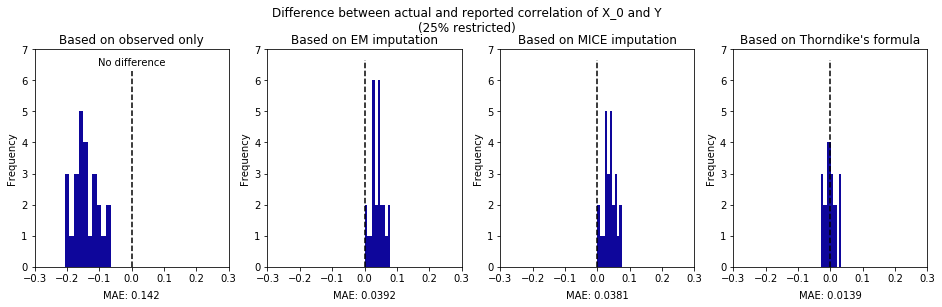

In [16]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(16, 16/4)

result_df.diff_corr_obs_25.plot(kind = 'hist',  color = '#0e069b', ax = axs[0])
result_df.diff_corr_em_25.plot(kind = 'hist',  color = '#0e069b', ax = axs[1])
result_df.diff_corr_mice_25.plot(kind = 'hist',  color = '#0e069b', ax = axs[2])
result_df.diff_corr_thorndike_25.plot(kind = 'hist',  color = '#0e069b', ax = axs[3])

for i in range(4):
    axs[i].set_xlim([-.3, .3])
    axs[i].set_ylim([0, 7])
    
axs[0].text(x=0, y=6.5, s = 'No difference', ha = 'center')
axs[0].axvline(x=0, ymin=0, ymax=.9, color = 'k', linestyle = '--')
axs[1].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
axs[2].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
axs[3].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
    
axs[0].set_title('Based on observed only')
axs[1].set_title('Based on EM imputation')
axs[2].set_title('Based on MICE imputation')
axs[3].set_title('Based on Thorndike\'s formula')


mae = abs(result_df[['diff_corr_obs_25', 'diff_corr_em_25',
                     'diff_corr_mice_25', 'diff_corr_thorndike_25']]).agg({'mean', 'median'})

axs[0].text(0, -1, 
           'MAE: {:.3}'.format(mae.loc['mean', 'diff_corr_obs_25']),
            size=10,
            horizontalalignment='center')
axs[1].text(0, -1, 
           'MAE: {:.3}'.format(mae.loc['mean', 'diff_corr_em_25']),
            size=10,
            horizontalalignment='center')
axs[2].text(0, -1, 
           'MAE: {:.3}'.format(mae.loc['mean', 'diff_corr_mice_25']),
            size=10,
            horizontalalignment='center')
                 
axs[3].text(0, -1, 
           'MAE: {:.3}'.format(mae.loc['mean', 'diff_corr_thorndike_25']),
            size=10,
            horizontalalignment='center')

fig.suptitle('Difference between actual and reported correlation of X_0 and Y\n(25% restricted)', va= 'center');

In our least restricted setting, underreporing of correlations is a consistent issue when using only observed outcomes. EM and MICE have a tendency to overcorrect in the most restricted setting. Thorndike's formula seems to yield an unbiased estimate.

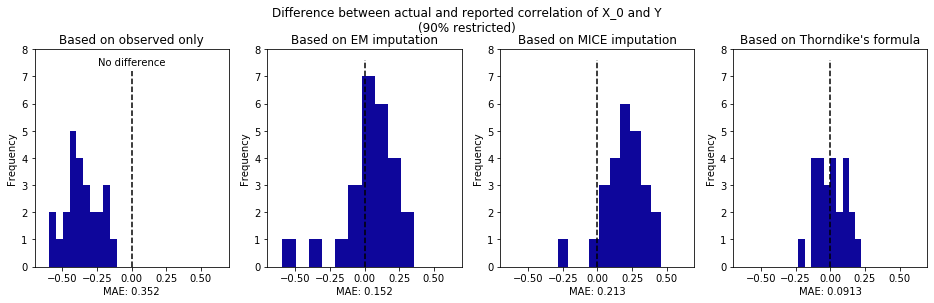

In [17]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(16, 16/4)

result_df.diff_corr_obs_90.plot(kind = 'hist',  color = '#0e069b', ax = axs[0])
result_df.diff_corr_em_90.plot(kind = 'hist',  color = '#0e069b', ax = axs[1])
result_df.diff_corr_mice_90.plot(kind = 'hist',  color = '#0e069b', ax = axs[2])
result_df.diff_corr_thorndike_90.plot(kind = 'hist',  color = '#0e069b', ax = axs[3])

for i in range(4):
    axs[i].set_xlim([-.7, .7])
    axs[i].set_ylim([0, 8])
    
axs[0].text(x=0, y=7.4, s = 'No difference', ha = 'center')
axs[0].axvline(x=0, ymin=0, ymax=.9, color = 'k', linestyle = '--')
axs[1].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
axs[2].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
axs[3].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
    
axs[0].set_title('Based on observed only')
axs[1].set_title('Based on EM imputation')
axs[2].set_title('Based on MICE imputation')
axs[3].set_title('Based on Thorndike\'s formula')

mae = abs(result_df[['diff_corr_obs_90', 'diff_corr_em_90',
                     'diff_corr_mice_90', 'diff_corr_thorndike_90']]).agg({'mean', 'median'})

axs[0].text(0, -1, 
           'MAE: {:.3}'.format(mae.loc['mean', 'diff_corr_obs_90']),
            size=10,
            horizontalalignment='center')
axs[1].text(0, -1, 
           'MAE: {:.3}'.format(mae.loc['mean', 'diff_corr_em_90']),
            size=10,
            horizontalalignment='center')
axs[2].text(0, -1, 
           'MAE: {:.3}'.format(mae.loc['mean', 'diff_corr_mice_90']),
            size=10,
            horizontalalignment='center')
axs[3].text(0, -1, 
           'MAE: {:.3}'.format(mae.loc['mean', 'diff_corr_thorndike_90']),
            size=10,
            horizontalalignment='center')

fig.suptitle('Difference between actual and reported correlation of X_0 and Y\n(90% restricted)', va= 'center');

Thorndike's formula produces the best estimates here as well. EM imputation is a bit better than MICE.

Note that MAE increases across the board as we get more restrictive. Having access to less data poses a more difficult challenge.

This has got me wondering, though, if the quality of the estimate is dependent on the level of correlation present in the data. For example, do we seee greater volatility in results when estimating very strong vs. very weak correlations, or do we hit our mark fairly consistently?

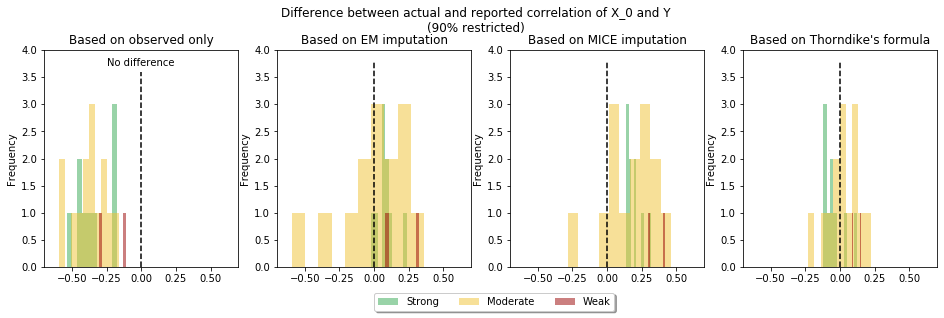

In [18]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(16, 16/4)

result_df[result_df.corr_type=='Strong'].diff_corr_obs_90.plot(kind = 'hist', 
                                                color = ['#34a853'], alpha = .5, ax = axs[0])
result_df[result_df.corr_type=='Moderate'].diff_corr_obs_90.plot(kind = 'hist', 
                                                color = ['#f1c232'], alpha = .5, ax = axs[0])
result_df[result_df.corr_type=='Weak'].diff_corr_obs_90.plot(kind = 'hist', 
                                                color = ['#990000'], alpha = .5, ax = axs[0])

result_df[result_df.corr_type=='Strong'].diff_corr_em_90.plot(kind = 'hist', label = 'Strong',
                                                color = ['#34a853'], alpha = .5, ax = axs[1])
result_df[result_df.corr_type=='Moderate'].diff_corr_em_90.plot(kind = 'hist', label = 'Moderate',
                                                color = ['#f1c232'], alpha = .5, ax = axs[1])
result_df[result_df.corr_type=='Weak'].diff_corr_em_90.plot(kind = 'hist', label = 'Weak',
                                                color = ['#990000'], alpha = .5, ax = axs[1])

result_df[result_df.corr_type=='Strong'].diff_corr_mice_90.plot(kind = 'hist', 
                                                color = ['#34a853'], alpha = .5, ax = axs[2])
result_df[result_df.corr_type=='Moderate'].diff_corr_mice_90.plot(kind = 'hist', 
                                                color = ['#f1c232'], alpha = .5, ax = axs[2])
result_df[result_df.corr_type=='Weak'].diff_corr_mice_90.plot(kind = 'hist', 
                                                color = ['#990000'], alpha = .5, ax = axs[2])


result_df[result_df.corr_type=='Strong'].diff_corr_thorndike_90.plot(kind = 'hist', 
                                                color = ['#34a853'], alpha = .5, ax = axs[3])
result_df[result_df.corr_type=='Moderate'].diff_corr_thorndike_90.plot(kind = 'hist', 
                                                color = ['#f1c232'], alpha = .5, ax = axs[3])
result_df[result_df.corr_type=='Weak'].diff_corr_thorndike_90.plot(kind = 'hist', 
                                                color = ['#990000'], alpha = .5, ax = axs[3])

for i in range(4):
    axs[i].set_xlim([-.7, .7])
    axs[i].set_ylim([0, 4])
    
axs[0].text(x=0, y=3.7, s = 'No difference', ha = 'center')
axs[0].axvline(x=0, ymin=0, ymax=.9, color = 'k', linestyle = '--')
axs[1].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
axs[2].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
axs[3].axvline(x=0, ymin=0, ymax=.95, color = 'k', linestyle = '--')
    
axs[0].set_title('Based on observed only')
axs[1].set_title('Based on EM imputation')
axs[2].set_title('Based on MICE imputation')
axs[3].set_title('Based on Thorndike\'s formula')

axs[1].legend(loc = (.5, -.2), fancybox=True, shadow=True, ncol=3)

fig.suptitle('Difference between actual and reported correlation of X_0 and Y\n(90% restricted)', va= 'center');

Data is quite thin for the strong and weak correlations, but given that they don't bunch at opposite ends of the spectrum in a clear way, I'm hesitant to claim any real differences in estimate error distributions due to strength of correlation.

Since we have the data, another thing I wondered about as I put this together was if the quality of imputation was related to the quality of correlation estimate in a postive manner. In other words, if we think EM imputation produces a better correlation estimate than MICE, does it also produce a better set of imputed results?

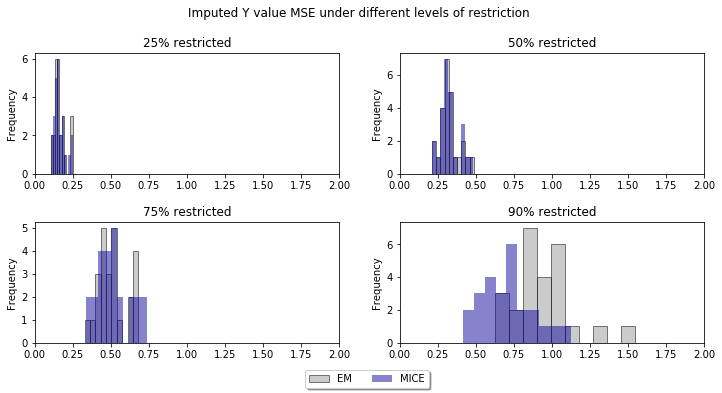

In [19]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 16/3)

result_df.mse_em_25.plot(kind = 'hist',  color = '#999999', edgecolor = 'k', alpha = .5, ax = axs[0, 0])
result_df.mse_mice_25.plot(kind = 'hist',  color = '#0e069b', alpha = .5, ax = axs[0, 0])

result_df.mse_em_50.plot(kind = 'hist',  color = '#999999', edgecolor = 'k', alpha = .5, ax = axs[0, 1])
result_df.mse_mice_50.plot(kind = 'hist',  color = '#0e069b', alpha = .5, ax = axs[0,1])

result_df.mse_em_75.plot(kind = 'hist',  color = '#999999', edgecolor = 'k', alpha = .5, ax = axs[1, 0])
result_df.mse_mice_75.plot(kind = 'hist',  color = '#0e069b', alpha = .5, ax = axs[1, 0])

result_df.mse_em_90.plot(kind = 'hist', label = 'EM', color = '#999999', edgecolor = 'k', alpha = .5, ax = axs[1, 1])
result_df.mse_mice_90.plot(kind = 'hist', label = 'MICE', color = '#0e069b', alpha = .5, ax = axs[1, 1])

for i in range(2):
    for j in range(2):
        axs[i, j].set_xlim([0, 2])
        
handles, labels = axs[1,1].get_legend_handles_labels()
# fig.legend(loc = (-.25, -.3), fancybox=True, shadow=True, ncol=2)

axs[0, 0].set_title('25% restricted')
axs[0, 1].set_title('50% restricted')
axs[1, 0].set_title('75% restricted')
axs[1, 1].set_title('90% restricted')
fig.subplots_adjust(hspace=.4)
plt.figlegend(handles, labels, fancybox=True, shadow=True, ncol=2, loc = 'lower center', bbox_to_anchor=(.425, 0)) 
fig.suptitle('Imputed Y value MSE under different levels of restriction', x = .5, y = 1);

Quality of imputation is similar across technqiues, excluding the case of 90% restriction. Here, MICE performs better than the EM algorithm. It is interesting that improved quality of imputation does not necessarily translate to improved correlation estimates.

# Back to the real problem

To justify use of high school GPA and ACT in making admissions decisions, Thorndike's Case C formula should be used.

In [23]:
# Data generation
np.random.seed(123)

mean_1 = 0
mean_2 = 0
mean_3 = 0

sd_1 = 1
sd_2 = 1
sd_3 = 1

cov_0 = .2
cov_1 = .6
cov_2 = .5

df = pd.DataFrame(
    np.random.multivariate_normal(\
        [mean_1, mean_2, mean_3],
        [[sd_1, cov_0, cov_1], 
         [cov_0, sd_2, cov_2], 
         [cov_1, cov_2, sd_3]],
        1000),
        columns = ['hs_gpa', 'act', 'college_gpa']
    )


# Scale and transform to get to more familiar distirbutions
df.hs_gpa = np.round(4 * (df.hs_gpa - df.hs_gpa.min()) / (df.hs_gpa - df.hs_gpa.min()).max(), 3)

df.act = 12 + np.round(24 * (df.act - df.act.min()) / (df.act - df.act.min()).max())

df.college_gpa = np.round(4 * (df.college_gpa - df.college_gpa.min()) / (df.college_gpa - df.college_gpa.min()).max(), 3)

# (Indirect) selection
df['admitted_25'] = (9*df.hs_gpa + df.act) > (9*df.hs_gpa + df.act).quantile(.25)
df['admitted_50'] = (9*df.hs_gpa + df.act) > (9*df.hs_gpa + df.act).quantile(.50)
df['admitted_75'] = (9*df.hs_gpa + df.act) > (9*df.hs_gpa + df.act).quantile(.75)
df['admitted_90'] = (9*df.hs_gpa + df.act) > (9*df.hs_gpa + df.act).quantile(.90)

df['selection_var'] = (9 * df.hs_gpa) + df.act

df['college_gpa_25'] = np.nan
df.loc[df.admitted_25, 'college_gpa_25'] =  df.college_gpa

df['college_gpa_50'] = np.nan
df.loc[df.admitted_50, 'college_gpa_50'] =  df.college_gpa

df['college_gpa_75'] = np.nan
df.loc[df.admitted_75, 'college_gpa_75'] =  df.college_gpa

df['college_gpa_90'] = np.nan
df.loc[df.admitted_90, 'college_gpa_90'] =  df.college_gpa

print('Estimated correlation between high school GPA and college GPA: {:.3}'\
    .format(
        thorndike_case_c(df, 'hs_gpa', 'selection_var', 'college_gpa_90')
    )
)

print('Estimated correlation between ACT and college GPA: {:.3}'\
    .format(
        thorndike_case_c(df, 'act', 'selection_var', 'college_gpa_90')
    )
)

print('Correlation between high school GPA and ACT: {:.3}'\
    .format(
        df.corr().loc['hs_gpa', 'act']
    )
)

Estimated correlation between high school GPA and college GPA: 0.421
Estimated correlation between ACT and college GPA: 0.559
Correlation between high school GPA and ACT: 0.155


We can show administrators that we are selecting on two variables that estimated to be relatively correlated with college GPA, while providing orthogonal information about the applicants.

Each variable has predictive power, and they are uncorrelated with each other, so we are justified in using them in admissions process (which is essentially generation and use of predictions about an applicant's ability to succeed.

# Summary

Range restriction can threaten our ability to truly understand the true correlation between selection and outcome variables.

We looked at a few techniques to recover the true understanding. Thorndike's Case C formula outperforms imputation using the EM algorithm and MICE across all levels of restriction, though imputing has some value here.

Moving forward, we ought to apply Thorndike's Case C formula if we are attempting to correlate selection and outcome variables.